In [ ]:
'''Example of CVAE on MNIST dataset using CNN

This VAE has a modular design. The encoder, decoder and vae
are 3 models that share weights. After training vae,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a gaussian dist with mean=0 and std=1.

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan.
"Learning structured output representation using
deep conditional generative models."
Advances in Neural Information Processing Systems. 2015.
'''

'Example of CVAE on MNIST dataset using CNN\n\nThis VAE has a modular design. The encoder, decoder and vae\nare 3 models that share weights. After training vae,\nthe encoder can be used to  generate latent vectors.\nThe decoder can be used to generate MNIST digits by sampling the\nlatent vector from a gaussian dist with mean=0 and std=1.\n\n[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan.\n"Learning structured output representation using\ndeep conditional generative models."\nAdvances in Neural Information Processing Systems. 2015.\n'

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import glob
from tensorflow.keras.preprocessing.image import load_img

In [4]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Implements reparameterization trick by sampling
    from a gaussian with zero mean and std=1.

    Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    Returns:
        sampled latent vector (tensor)
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def plot_results(models,
                 data,
                 y_label,
                 batch_size=128,
                 model_name="cvae_mnist"):
    """Plots 2-dim mean values of Q(z|X) using labels 
        as color gradient then, plot MNIST digits as 
        function of 2-dim latent vector

    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        y_label (array): one-hot vector of which digit to plot
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z, _, _ = encoder.predict([x_test, to_categorical(y_test)],
                              batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "%05d.png" % np.argmax(y_label))
    # display a 10x10 2D manifold of the digit (y_label)
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, y_label])
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [6]:
from google.colab import drive # import images from xdrive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/project/data")
os.chdir("/content/drive/MyDrive/project/fault2d_data")
!du -h ../data/saltall
!du -h ../fault2d_data/2D_train/fault

Mounted at /content/drive
74M	../data/saltall
5.0K	../fault2d_data/2D_train/fault/.ipynb_checkpoints
2.3M	../fault2d_data/2D_train/fault


In [7]:
# Training set
folder_train_x = "../data/saltall/*.png"
folder_train_y = "../fault2d_data/2D_train/fault/*.png"
image_size = (128, 128)


In [12]:
xfiles = glob.glob(folder_train_y) #get all documents in folder_train_x
xfiles = np.sort(xfiles)
train_images = np.array([np.array(load_img(i, color_mode="grayscale")) / 255 for i in xfiles])
print(train_images.shape)

(2600, 128, 128)


In [13]:
import cv2
def resizeImage(img, size = 64):
    imgR = np.zeros((img.shape[0],size,size))
    for i in range(img.shape[0]):
        imgR[i] = cv2.resize(img[i],(size,size))
    return(imgR)
train_images = resizeImage(train_images)
print(train_images.shape)

(2600, 64, 64)


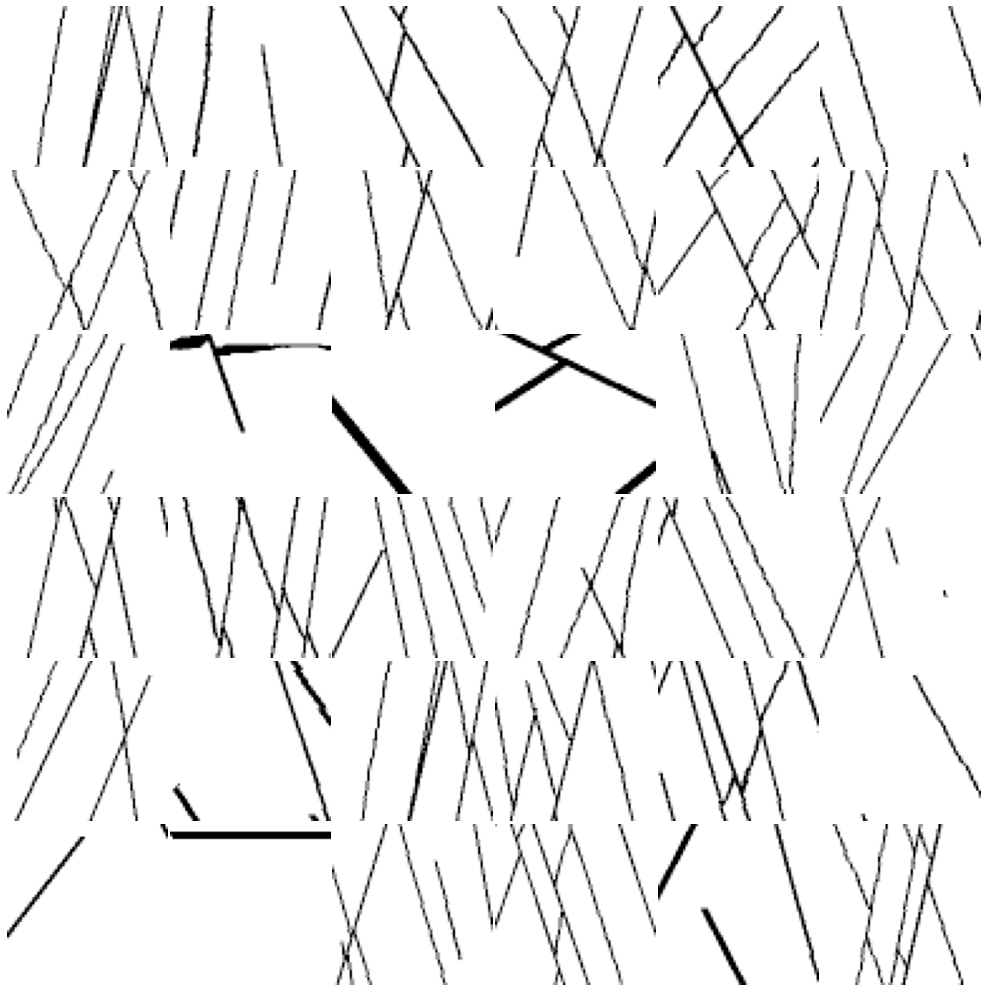

In [14]:

def plotImageTransp(file1, k, alpha = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = np.random.randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    return(fig)
fig = plotImageTransp(train_images, k = 6) 

In [15]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [16]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [17]:
# compute the number of labels
num_labels = len(np.unique(y_train))

In [18]:
# network parameters
input_shape = (image_size, image_size, 1)
label_shape = (num_labels, )
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

In [19]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
y_labels = Input(shape=label_shape, name='class_labels')
x = Dense(image_size * image_size)(y_labels)
x = Reshape((image_size, image_size, 1))(x)
x = concatenate([inputs, x])
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [20]:
# shape info needed to build decoder model
shape = K.int_shape(x)

In [21]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [22]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
____________________________________________________________________________________________

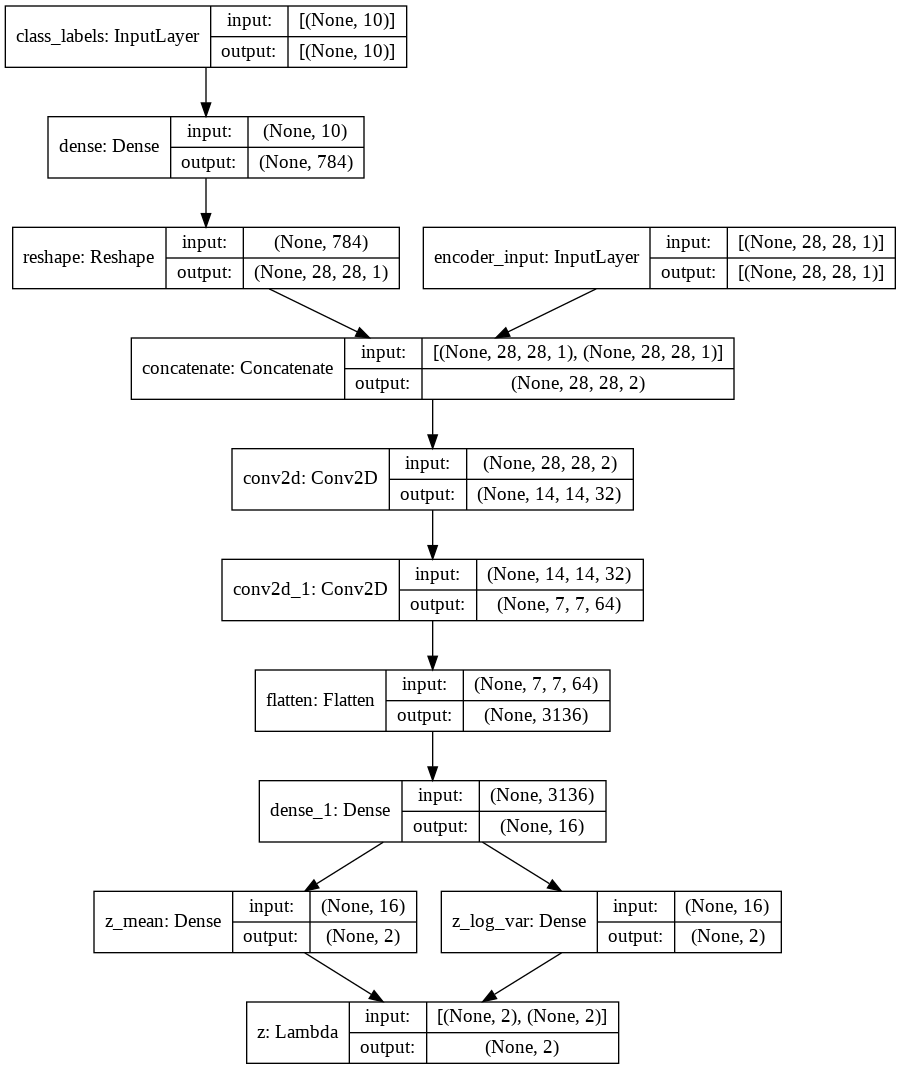

In [50]:
# instantiate encoder model
encoder = Model([inputs, y_labels],
                [z_mean, z_log_var, z], 
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='cvae_cnn_encoder.png', 
           show_shapes=True)

In [59]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = concatenate([latent_inputs, y_labels])
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [60]:
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

In [61]:
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_sampling (InputLayer)         [(None, 2)]          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 12)           0           z_sampling[0][0]                 
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 3136)         40768       concatenate_2[0][0]        

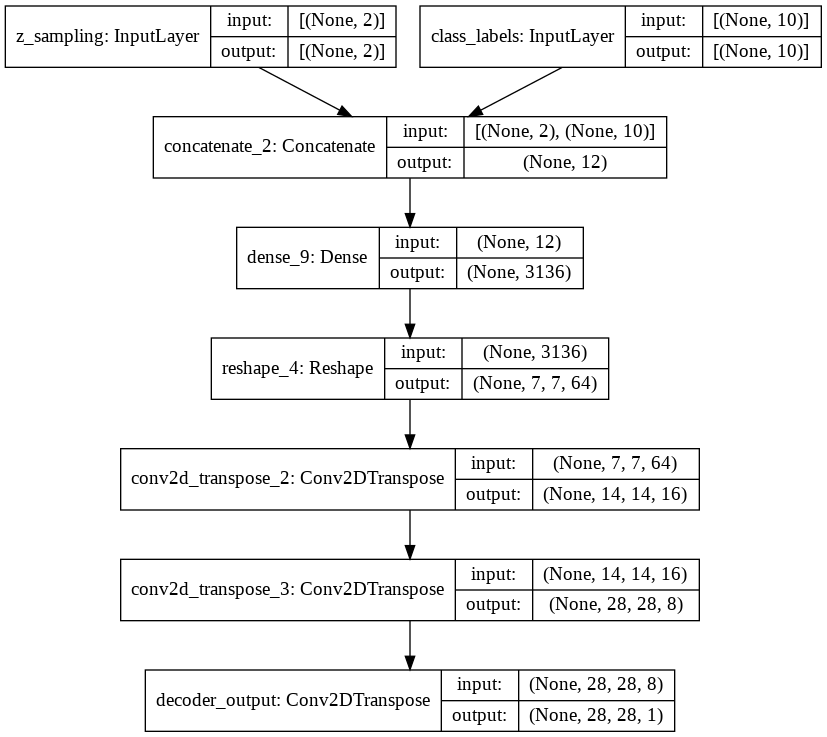

In [62]:
# instantiate decoder model
decoder = Model([latent_inputs, y_labels],
                outputs, 
                name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='cvae_cnn_decoder.png', 
           show_shapes=True)

In [63]:
# instantiate vae model
outputs = decoder([encoder([inputs, y_labels])[2], y_labels])
cvae = Model([inputs, y_labels], outputs, name='cvae')

In [64]:
models = (encoder, decoder)
data = (x_test, y_test)

In [65]:
beta = 1.0
print("CVAE")
model_name = "cvae_cnn_mnist"
save_dir = "cvae_weights"

CVAE


In [66]:
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))

In [67]:
!pip install pydot

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 77988       encoder_input[0][0]              
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    51233       encoder[0][2]                 

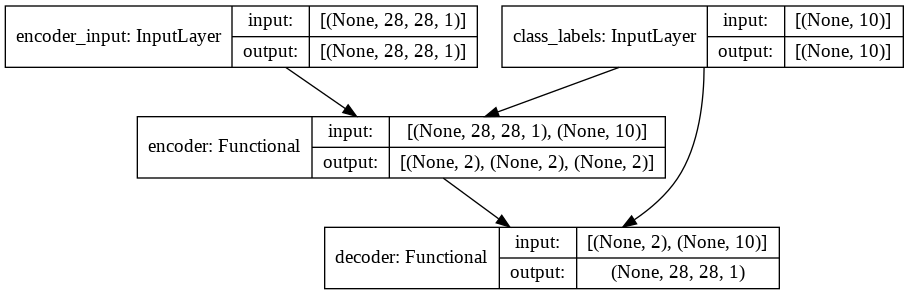

In [73]:
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 * beta
cvae_loss = K.mean(reconstruction_loss + kl_loss)
#cvae.add_loss(cvae_loss)
cvae.compile(optimizer='rmsprop')
cvae.summary()
plot_model(cvae, to_file='cvae_cnn.png', show_shapes=True)

In [85]:
args_weights = " ".join(str(x) for x in args.weights)


AttributeError: ignored

In [83]:


if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
if args_weights:
    filepath = os.path.join(save_dir, args_weights)
    cvae = cvae.load_weights(filepath)
else:
    cvae.fit([x_train, to_categorical(y_train)],
              epochs=epochs,
              batch_size=batch_size,
              validation_data=([x_test, to_categorical(y_test)], None))
    filename = model_name + '.tf'
    filepath = os.path.join(save_dir, filename)
    cvae.save_weights(filepath)

if args.digit in range(0, num_labels):
    digit = np.array([args.digit])
else:
    digit = np.random.randint(0, num_labels, 1)

print("CVAE for digit %d" % digit)
y_label = np.eye(num_labels)[digit]
plot_results(models,
              data,
              y_label=y_label,
              batch_size=batch_size,
                 model_name=model_name)

NotFoundError: ignored

In [86]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load tf model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use binary cross entropy instead of mse (default)"
    parser.add_argument("--bce", help=help_, action='store_true')
    help_ = "Specify a specific digit to generate"
    parser.add_argument("-d", "--digit", type=int, help=help_)
    help_ = "Beta in Beta-CVAE. Beta > 1. Default is 1.0 (CVAE)"
    parser.add_argument("-b", "--beta", type=float, help=help_)
    args = parser.parse_args()
    models = (encoder, decoder)
    data = (x_test, y_test)

    if args.beta is None or args.beta < 1.0:
        beta = 1.0
        print("CVAE")
        model_name = "cvae_cnn_mnist"
        save_dir = "cvae_weights"
    else:
        beta = args.beta
        print("Beta-CVAE with beta=", beta)
        model_name = "beta-cvae_cnn_mnist"
        save_dir = "beta-cvae_weights"

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.bce:
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))
    else:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

    reconstruction_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5 * beta
    cvae_loss = K.mean(reconstruction_loss + kl_loss)
    cvae.add_loss(cvae_loss)
    cvae.compile(optimizer='rmsprop')
    cvae.summary()
    plot_model(cvae, to_file='cvae_cnn.png', show_shapes=True)

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if args.weights:
        filepath = os.path.join(save_dir, args.weights)
        cvae = cvae.load_weights(filepath)
    else:
        cvae.fit([x_train, to_categorical(y_train)],
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=([x_test, to_categorical(y_test)], None))
        filename = model_name + '.tf'
        filepath = os.path.join(save_dir, filename)
        cvae.save_weights(filepath)

    if args.digit in range(0, num_labels):
        digit = np.array([args.digit])
    else:
        digit = np.random.randint(0, num_labels, 1)

    print("CVAE for digit %d" % digit)
    y_label = np.eye(num_labels)[digit]
    plot_results(models,
                 data,
                 y_label=y_label,
                 batch_size=batch_size,
                 model_name=model_name)

usage: ipykernel_launcher.py [-h] [-w WEIGHTS] [--bce] [-d DIGIT] [-b BETA]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-25bd1243-65e0-4862-b515-4198c433f21c.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
